## How many articles are in the "2016 deaths" category in the English Wikipedia?

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [4]:
import pywikibot
site = pywikibot.Site('en', 'wikipedia')

In [5]:
years = range(2000,2017)
deathperyear = {}
for year in years:
    deathperyear[year] = 0

In [6]:
for year in years:
    yearstr = 'Category:' + str(year) + "_deaths"
    deathcat = pywikibot.Page(site, yearstr)
    for page in site.categorymembers(deathcat):
        if page.title().find("List_of") is -1:
            deathperyear[year] += 1

Sleeping for 5.0 seconds, 2016-12-26 22:39:41
Sleeping for 5.0 seconds, 2016-12-26 22:39:46


In [7]:
deathperyear

{2000: 4947,
 2001: 5112,
 2002: 5376,
 2003: 5570,
 2004: 5690,
 2005: 6132,
 2006: 6586,
 2007: 6871,
 2008: 7177,
 2009: 7318,
 2010: 7489,
 2011: 7263,
 2012: 7244,
 2013: 7610,
 2014: 7723,
 2015: 7587,
 2016: 6717}

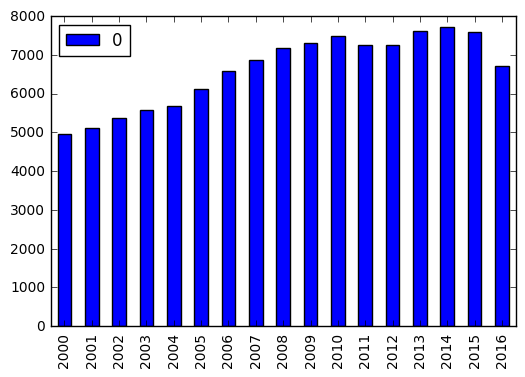

In [8]:
df = pd.DataFrame.from_dict(deathperyear,orient='index')
df = df.sort_index()
df.plot(kind='bar')

In [9]:
f = open('death_pageviews_2016.tsv', 'w')
f.write("title, 2016_views")
f.close()

## Pageviews for articles in the "2016 Deaths" category

In [10]:
from mwviews.api import PageviewsClient

def yearly_views(title,year):
    p = PageviewsClient(2)
    startdate = str(year) + "010100"
    enddate = str(year) + "123100"
    d = p.article_views('en.wikipedia', title, granularity='monthly', start=startdate, end=enddate)
    total = 0
    for month in d.values():
        for titlecount in month.values():
            if titlecount is not None:
                total += titlecount
    return total

In [11]:
pageviews_2016 = {}
deaths_per_year = 0
over500k_views = 0

### Querying the pageview API for all the articles in the "2016 deaths" category

This throws some errors for a few pages (in pink boxes below) which we will ignore.

In [12]:
year = 2016
yearstr = 'Category:' + str(year) + "_deaths"
deathcat = pywikibot.Page(site, yearstr)
for page in site.categorymembers(deathcat):
    if page.title().find("List_of") is -1 and page.title().find("Category:") is -1:
        deaths_per_year += 1

        try:
            page_yearly_views = yearly_views(page.title(),year)
        except Exception as e:
            page_yearly_views = 0

        pageviews_2016[page.title()] = page_yearly_views

        if(page_yearly_views > 500000):
            over500k_views += 1
        output = str(page.title()) + "\t" + str(page_yearly_views) + "\n"
        f = open('death_pageviews_2016.tsv', 'a')
        f.write(output)
        f.close()

ERROR while fetching and parsing ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Jacques_Cohen_%28actor%29/daily/2016010100/2016123100']


Traceback (most recent call last):
  File "/srv/paws/lib/python3.4/site-packages/mwviews/api/pageviews.py", line 139, in article_views
    'The pageview API returned nothing useful at: {}'.format(urls)
Exception: The pageview API returned nothing useful at: ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Jacques_Cohen_%28actor%29/daily/2016010100/2016123100']


ERROR while fetching and parsing ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Lalit_Mohan_Nath/daily/2016010100/2016123100']


Traceback (most recent call last):
  File "/srv/paws/lib/python3.4/site-packages/mwviews/api/pageviews.py", line 139, in article_views
    'The pageview API returned nothing useful at: {}'.format(urls)
Exception: The pageview API returned nothing useful at: ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Lalit_Mohan_Nath/daily/2016010100/2016123100']


ERROR while fetching and parsing ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Andre_Martel/daily/2016010100/2016123100']


Traceback (most recent call last):
  File "/srv/paws/lib/python3.4/site-packages/mwviews/api/pageviews.py", line 139, in article_views
    'The pageview API returned nothing useful at: {}'.format(urls)
Exception: The pageview API returned nothing useful at: ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Andre_Martel/daily/2016010100/2016123100']


ERROR while fetching and parsing ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Marvin_E._Miller_Jr./daily/2016010100/2016123100']


Traceback (most recent call last):
  File "/srv/paws/lib/python3.4/site-packages/mwviews/api/pageviews.py", line 139, in article_views
    'The pageview API returned nothing useful at: {}'.format(urls)
Exception: The pageview API returned nothing useful at: ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Marvin_E._Miller_Jr./daily/2016010100/2016123100']


ERROR while fetching and parsing ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Patricia_Graham_%28pilot%29/daily/2016010100/2016123100']


Traceback (most recent call last):
  File "/srv/paws/lib/python3.4/site-packages/mwviews/api/pageviews.py", line 139, in article_views
    'The pageview API returned nothing useful at: {}'.format(urls)
Exception: The pageview API returned nothing useful at: ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Patricia_Graham_%28pilot%29/daily/2016010100/2016123100']


In [13]:
len(pageviews_2016)

6714

In [53]:
over500k_views

104

In [14]:
pageviews_df = pd.DataFrame.from_dict(pageviews_2016,orient='index')

In [15]:
df_sorted = pageviews_df.sort_values(0, ascending=False)

### Getting the daily pageview counts for the top 1,001 articles (includes the "Deaths in 2016" article)

In [45]:
articles = []
for index,row in df_sorted.head(1001).iterrows():
    articles.append(index)

In [46]:
len(articles)

1001

In [47]:
!pip install mwviews
from mwviews.api import PageviewsClient
p = PageviewsClient(10)

startdate = "2016010100"
enddate = "2016123100"

In [48]:
counts_dict = p.article_views('en.wikipedia', articles, granularity='daily', start=startdate, end=enddate)

In [49]:
counts_df = pd.DataFrame.from_dict(counts_dict, orient='index')
counts_df = counts_df.fillna(0)

In [50]:
counts_df.to_csv("deaths-enwiki-2016.csv")

### Plotting pageviews per day of top 5 articles

In [51]:
articles = []
for index,row in df_sorted.head(6).iterrows():
    articles.append(index)
    
counts_dict = p.article_views('en.wikipedia', articles, granularity='daily', start=startdate, end=enddate)
counts_df = pd.DataFrame.from_dict(counts_dict, orient='index')
counts_df = counts_df.fillna(0)

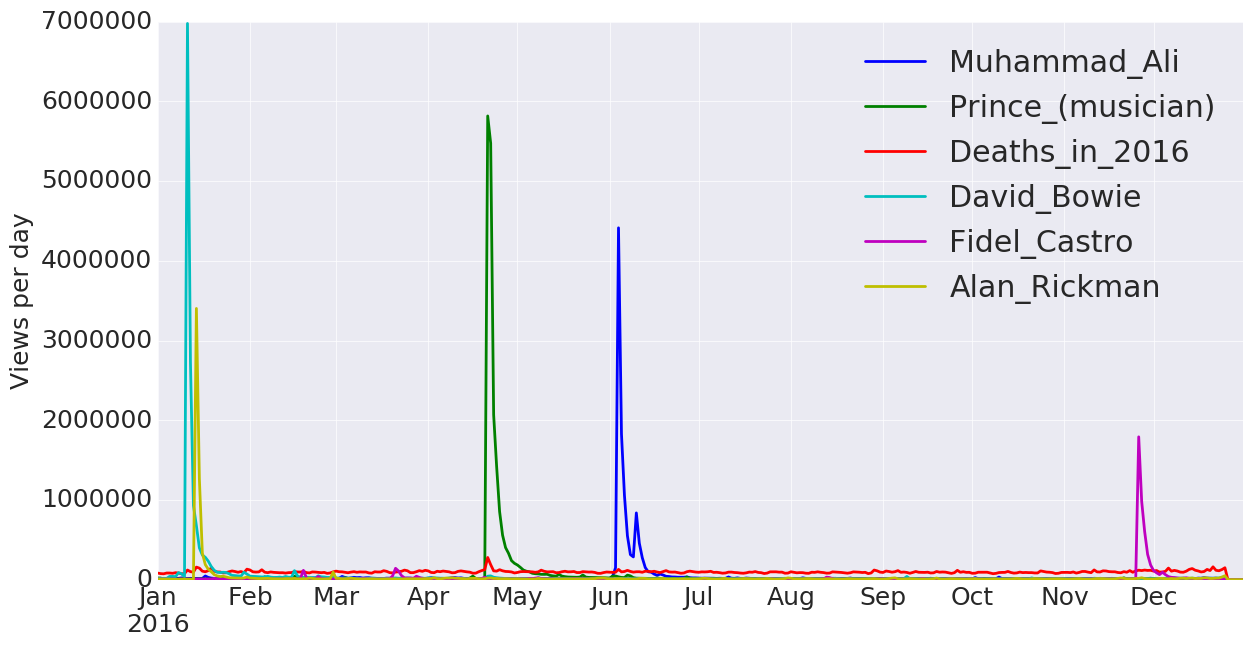

In [52]:
matplotlib.style.use('seaborn-darkgrid')


font = {'family' : 'normal',
        'weight'  : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

plt.figure(figsize=[14,7.2])
for title in counts_df:
    fig = counts_df[title].plot(legend=True, linewidth=2)
    fig.set_ylabel('Views per day')
plt.legend(loc='best')

